## Potential Growth Area Mapping

This analysis identifies areas with high potential for future urban development in Anuradhapura using multiple criteria:
- Proximity to existing urban areas
- Distance from current development
- Terrain suitability (NDVI analysis)
- Growth trend patterns
- Infrastructure accessibility

Potential Growth Area Analysis - Anuradhapura
AOI loaded: 22 polygon(s)
Latest urban file: Urban_20250401.tif
Latest NDVI file: NDVI_20250401.tif
Urban data shape: (4074, 3815)
NDVI data shape: (4074, 3815)
Distance calculation completed. Max distance: 1496.5 pixels
Terrain suitability calculation completed
Development potential score calculation completed
Potential zones classification completed
Zone 0 (No Potential/Existing Urban): 301,005 pixels (1.9%)
Zone 1 (Very Low Potential): 3,048,261 pixels (19.6%)
Zone 2 (Low Potential): 3,048,261 pixels (19.6%)
Zone 3 (Medium Potential): 3,048,319 pixels (19.6%)
Zone 4 (High Potential): 3,048,203 pixels (19.6%)
Zone 5 (Very High Potential): 3,048,261 pixels (19.6%)
Results saved to GeoTIFF files


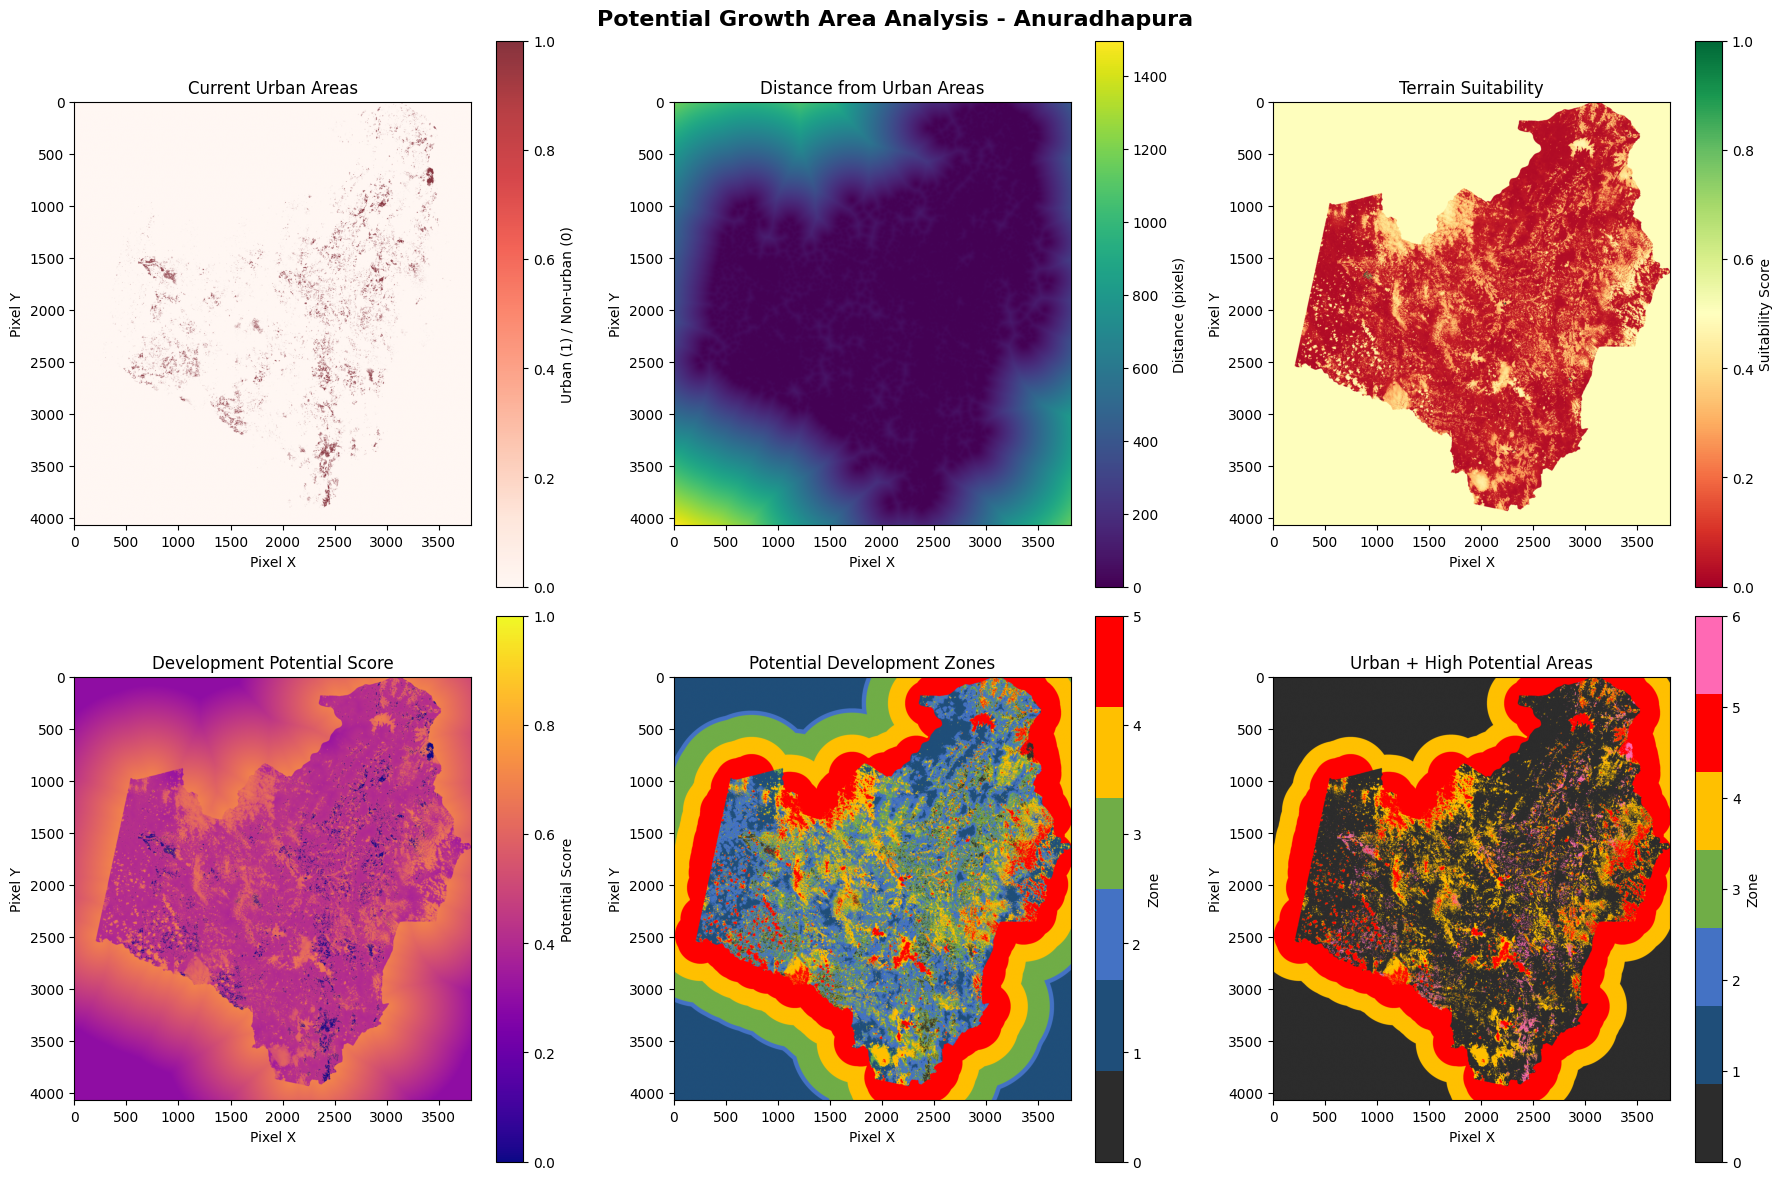


POTENTIAL GROWTH ANALYSIS SUMMARY

Area Analysis (assuming 30m pixel resolution):
Total analyzed area: 13988.08 km²
Current urban area: 270.90 km²
High potential area (zones 4-5): 5486.82 km²
Very high potential area (zone 5): 2743.43 km²

Potential expansion ratio: 20.3x current urban area

Detailed Zone Distribution:
No Potential/Existing Urban: 270.90 km² (1.9%)
Very Low Potential: 2743.43 km² (19.6%)
Low Potential: 2743.43 km² (19.6%)
Medium Potential: 2743.49 km² (19.6%)
High Potential: 2743.38 km² (19.6%)
Very High Potential: 2743.43 km² (19.6%)

DEVELOPMENT RECOMMENDATIONS

🎯 PRIORITY DEVELOPMENT AREAS:
   • Zone 5 (Very High Potential): 2743.43 km²
   • Zone 4 (High Potential): 2743.38 km²

📍 DEVELOPMENT STRATEGY:
   1. Focus initial expansion on Zone 5 areas (highest priority)
   2. Zone 4 areas suitable for secondary development phase
   3. Zones 2-3 for long-term planning consideration

🏗️ INFRASTRUCTURE PLANNING:
   • Prioritize roads/utilities to high potential zones
   •

In [5]:
import os
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.features import shapes
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# CONFIGURATION
BASE_DIR = "../.."
AOI_PATH = os.path.join(BASE_DIR, "AOI/Anuradhapura_District_AOI.geojson")
PROCESSED_DIR = os.path.join(BASE_DIR, "Processed_Monthly")
OUTPUT_DIR = os.path.join(BASE_DIR, "Potential_Growth_Analysis")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Potential Growth Area Analysis - Anuradhapura")
print("=" * 50)

# LOAD AOI
aoi = gpd.read_file(AOI_PATH)
print(f"AOI loaded: {len(aoi)} polygon(s)")

# FIND LATEST URBAN AND NDVI FILES
def find_latest_files():
    """Find the most recent urban and NDVI files"""
    urban_files = []
    ndvi_files = []
    
    if os.path.exists(PROCESSED_DIR):
        for file in os.listdir(PROCESSED_DIR):
            if file.startswith("Urban_") and file.endswith(".tif"):
                urban_files.append(file)
            elif file.startswith("NDVI_") and file.endswith(".tif"):
                ndvi_files.append(file)
    
    urban_files.sort()
    ndvi_files.sort()
    
    latest_urban = urban_files[-1] if urban_files else None
    latest_ndvi = ndvi_files[-1] if ndvi_files else None
    
    return latest_urban, latest_ndvi

latest_urban_file, latest_ndvi_file = find_latest_files()
print(f"Latest urban file: {latest_urban_file}")
print(f"Latest NDVI file: {latest_ndvi_file}")

# LOAD RASTER DATA
def load_raster_data(file_path):
    """Load raster data and return array with metadata"""
    with rasterio.open(file_path) as src:
        data = src.read(1)
        transform = src.transform
        crs = src.crs
        bounds = src.bounds
    return data, transform, crs, bounds

# Load latest urban and NDVI data
urban_path = os.path.join(PROCESSED_DIR, latest_urban_file)
ndvi_path = os.path.join(PROCESSED_DIR, latest_ndvi_file)

urban_data, transform, crs, bounds = load_raster_data(urban_path)
ndvi_data, _, _, _ = load_raster_data(ndvi_path)

print(f"Urban data shape: {urban_data.shape}")
print(f"NDVI data shape: {ndvi_data.shape}")

# CALCULATE DISTANCE FROM EXISTING URBAN AREAS
def calculate_distance_from_urban(urban_array):
    """Calculate euclidean distance from existing urban areas"""
    # Create binary urban mask
    urban_mask = (urban_array == 1)
    
    # Calculate distance transform
    distance = ndimage.distance_transform_edt(~urban_mask)
    
    return distance

distance_from_urban = calculate_distance_from_urban(urban_data)
print(f"Distance calculation completed. Max distance: {distance_from_urban.max():.1f} pixels")

# CALCULATE TERRAIN SUITABILITY
def calculate_terrain_suitability(ndvi_array):
    """Calculate terrain suitability based on NDVI (lower NDVI = more suitable for development)"""
    # Normalize NDVI to 0-1 scale
    ndvi_norm = np.clip(ndvi_array, -1, 1)
    
    # Invert NDVI so that lower vegetation = higher suitability
    # Areas with NDVI < 0.3 are considered more suitable for development
    suitability = 1 - ((ndvi_norm + 1) / 2)  # Convert -1,1 to 0,1 then invert
    
    # Apply threshold - very high vegetation areas get low suitability
    suitability = np.where(ndvi_norm > 0.5, suitability * 0.3, suitability)
    
    return suitability

terrain_suitability = calculate_terrain_suitability(ndvi_data)
print("Terrain suitability calculation completed")

# CALCULATE DEVELOPMENT POTENTIAL SCORE
def calculate_potential_score(distance_from_urban, terrain_suitability, urban_mask):
    """Calculate overall development potential score"""
    
    # Normalize distance (closer to urban = higher score)
    max_distance = np.percentile(distance_from_urban, 95)  # Use 95th percentile to avoid outliers
    distance_score = 1 - np.clip(distance_from_urban / max_distance, 0, 1)
    
    # Combine factors with weights
    weights = {
        'proximity': 0.4,    # 40% weight to proximity to existing urban
        'terrain': 0.6       # 60% weight to terrain suitability
    }
    
    potential_score = (
        weights['proximity'] * distance_score +
        weights['terrain'] * terrain_suitability
    )
    
    # Exclude already urban areas
    potential_score = np.where(urban_mask, 0, potential_score)
    
    return potential_score, distance_score

urban_mask = (urban_data == 1)
potential_score, distance_score = calculate_potential_score(
    distance_from_urban, terrain_suitability, urban_mask
)

print("Development potential score calculation completed")

# CLASSIFY POTENTIAL ZONES
def classify_potential_zones(potential_score, num_classes=5):
    """Classify areas into potential development zones"""
    
    # Calculate percentile thresholds
    thresholds = [
        np.percentile(potential_score[potential_score > 0], 20),
        np.percentile(potential_score[potential_score > 0], 40),
        np.percentile(potential_score[potential_score > 0], 60),
        np.percentile(potential_score[potential_score > 0], 80)
    ]
    
    zones = np.zeros_like(potential_score, dtype=int)
    zones = np.where(potential_score > thresholds[3], 5, zones)  # Very High
    zones = np.where((potential_score > thresholds[2]) & (potential_score <= thresholds[3]), 4, zones)  # High
    zones = np.where((potential_score > thresholds[1]) & (potential_score <= thresholds[2]), 3, zones)  # Medium
    zones = np.where((potential_score > thresholds[0]) & (potential_score <= thresholds[1]), 2, zones)  # Low
    zones = np.where((potential_score > 0) & (potential_score <= thresholds[0]), 1, zones)  # Very Low
    
    return zones, thresholds

potential_zones, thresholds = classify_potential_zones(potential_score)

zone_labels = {
    0: 'No Potential/Existing Urban',
    1: 'Very Low Potential',
    2: 'Low Potential', 
    3: 'Medium Potential',
    4: 'High Potential',
    5: 'Very High Potential'
}

print("Potential zones classification completed")
for i, label in zone_labels.items():
    count = np.sum(potential_zones == i)
    percentage = (count / potential_zones.size) * 100
    print(f"Zone {i} ({label}): {count:,} pixels ({percentage:.1f}%)")

# SAVE RESULTS TO GEOTIFF
def save_raster(array, output_path, transform, crs):
    """Save numpy array as GeoTIFF"""
    with rasterio.open(
        output_path, 'w',
        driver='GTiff',
        height=array.shape[0],
        width=array.shape[1],
        count=1,
        dtype=array.dtype,
        crs=crs,
        transform=transform,
    ) as dst:
        dst.write(array, 1)

# Save all outputs
save_raster(potential_score.astype(np.float32), 
           os.path.join(OUTPUT_DIR, "potential_score.tif"), transform, crs)
save_raster(potential_zones.astype(np.uint8), 
           os.path.join(OUTPUT_DIR, "potential_zones.tif"), transform, crs)
save_raster(distance_score.astype(np.float32), 
           os.path.join(OUTPUT_DIR, "proximity_score.tif"), transform, crs)
save_raster(terrain_suitability.astype(np.float32), 
           os.path.join(OUTPUT_DIR, "terrain_suitability.tif"), transform, crs)

print("Results saved to GeoTIFF files")

# VISUALIZATION
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Potential Growth Area Analysis - Anuradhapura', fontsize=16, fontweight='bold')

# 1. Current Urban Areas
im1 = axes[0, 0].imshow(urban_data, cmap='Reds', alpha=0.8)
axes[0, 0].set_title('Current Urban Areas')
axes[0, 0].set_xlabel('Pixel X')
axes[0, 0].set_ylabel('Pixel Y')
plt.colorbar(im1, ax=axes[0, 0], label='Urban (1) / Non-urban (0)')

# 2. Distance from Urban
im2 = axes[0, 1].imshow(distance_from_urban, cmap='viridis')
axes[0, 1].set_title('Distance from Urban Areas')
axes[0, 1].set_xlabel('Pixel X')
axes[0, 1].set_ylabel('Pixel Y')
plt.colorbar(im2, ax=axes[0, 1], label='Distance (pixels)')

# 3. Terrain Suitability
im3 = axes[0, 2].imshow(terrain_suitability, cmap='RdYlGn', vmin=0, vmax=1)
axes[0, 2].set_title('Terrain Suitability')
axes[0, 2].set_xlabel('Pixel X')
axes[0, 2].set_ylabel('Pixel Y')
plt.colorbar(im3, ax=axes[0, 2], label='Suitability Score')

# 4. Development Potential Score
im4 = axes[1, 0].imshow(potential_score, cmap='plasma', vmin=0, vmax=1)
axes[1, 0].set_title('Development Potential Score')
axes[1, 0].set_xlabel('Pixel X')
axes[1, 0].set_ylabel('Pixel Y')
plt.colorbar(im4, ax=axes[1, 0], label='Potential Score')

# 5. Potential Zones
colors = ['#2c2c2c', '#1f4e79', '#4472c4', '#70ad47', '#ffc000', '#ff0000']
im5 = axes[1, 1].imshow(potential_zones, cmap=plt.matplotlib.colors.ListedColormap(colors))
axes[1, 1].set_title('Potential Development Zones')
axes[1, 1].set_xlabel('Pixel X')
axes[1, 1].set_ylabel('Pixel Y')
cbar5 = plt.colorbar(im5, ax=axes[1, 1], label='Zone')
cbar5.set_ticks(range(6))
cbar5.set_ticklabels([f"{i}" for i in range(6)])

# 6. Combined View (Urban + High Potential)
combined = np.zeros_like(potential_zones)
combined = np.where(urban_data == 1, 6, combined)  # Existing urban in red
combined = np.where((potential_zones >= 4) & (urban_data == 0), potential_zones, combined)  # High potential areas

im6 = axes[1, 2].imshow(combined, cmap=plt.matplotlib.colors.ListedColormap(colors + ['#ff69b4']))
axes[1, 2].set_title('Urban + High Potential Areas')
axes[1, 2].set_xlabel('Pixel X')
axes[1, 2].set_ylabel('Pixel Y')
plt.colorbar(im6, ax=axes[1, 2], label='Zone')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "potential_growth_analysis.png"), dpi=300, bbox_inches='tight')
plt.show()

# STATISTICS AND SUMMARY
print("\n" + "="*50)
print("POTENTIAL GROWTH ANALYSIS SUMMARY")
print("="*50)

# Calculate areas (assuming 30m pixel resolution)
pixel_area_km2 = (30 * 30) / 1e6  # 30m x 30m pixel in km²

print(f"\nArea Analysis (assuming 30m pixel resolution):")
total_area = potential_zones.size * pixel_area_km2
print(f"Total analyzed area: {total_area:.2f} km²")

current_urban_area = np.sum(urban_data == 1) * pixel_area_km2
print(f"Current urban area: {current_urban_area:.2f} km²")

high_potential_area = np.sum(potential_zones >= 4) * pixel_area_km2
print(f"High potential area (zones 4-5): {high_potential_area:.2f} km²")

very_high_potential_area = np.sum(potential_zones == 5) * pixel_area_km2
print(f"Very high potential area (zone 5): {very_high_potential_area:.2f} km²")

print(f"\nPotential expansion ratio: {high_potential_area/current_urban_area:.1f}x current urban area")

# Zone distribution
print(f"\nDetailed Zone Distribution:")
for zone_id, label in zone_labels.items():
    area = np.sum(potential_zones == zone_id) * pixel_area_km2
    percentage = (np.sum(potential_zones == zone_id) / potential_zones.size) * 100
    print(f"{label}: {area:.2f} km² ({percentage:.1f}%)")

# RECOMMENDATIONS
print(f"\n" + "="*50)
print("DEVELOPMENT RECOMMENDATIONS")
print("="*50)

print(f"""
🎯 PRIORITY DEVELOPMENT AREAS:
   • Zone 5 (Very High Potential): {very_high_potential_area:.2f} km²
   • Zone 4 (High Potential): {np.sum(potential_zones == 4) * pixel_area_km2:.2f} km²

📍 DEVELOPMENT STRATEGY:
   1. Focus initial expansion on Zone 5 areas (highest priority)
   2. Zone 4 areas suitable for secondary development phase
   3. Zones 2-3 for long-term planning consideration

🏗️ INFRASTRUCTURE PLANNING:
   • Prioritize roads/utilities to high potential zones
   • Consider environmental impact in medium potential areas
   • Preserve areas with very low potential for green spaces

📊 GROWTH CAPACITY:
   • Current urban: {current_urban_area:.2f} km²
   • High potential: {high_potential_area:.2f} km²
   • Expansion potential: {high_potential_area/current_urban_area:.1f}x current size
""")

print("\n✅ Potential growth area analysis completed!")
print(f"📁 Results saved to: {OUTPUT_DIR}")
print("\nFiles generated:")
print("• potential_growth_analysis.png - Comprehensive visualization")
print("• potential_score.tif - Development potential scores")
print("• potential_zones.tif - Classified development zones")
print("• proximity_score.tif - Proximity to urban areas")
print("• terrain_suitability.tif - Terrain suitability for development")

## How to Open and View TIF Images

The analysis generates several GeoTIFF files that can be opened in different ways:

🗺️ VIEWING GENERATED TIF FILES


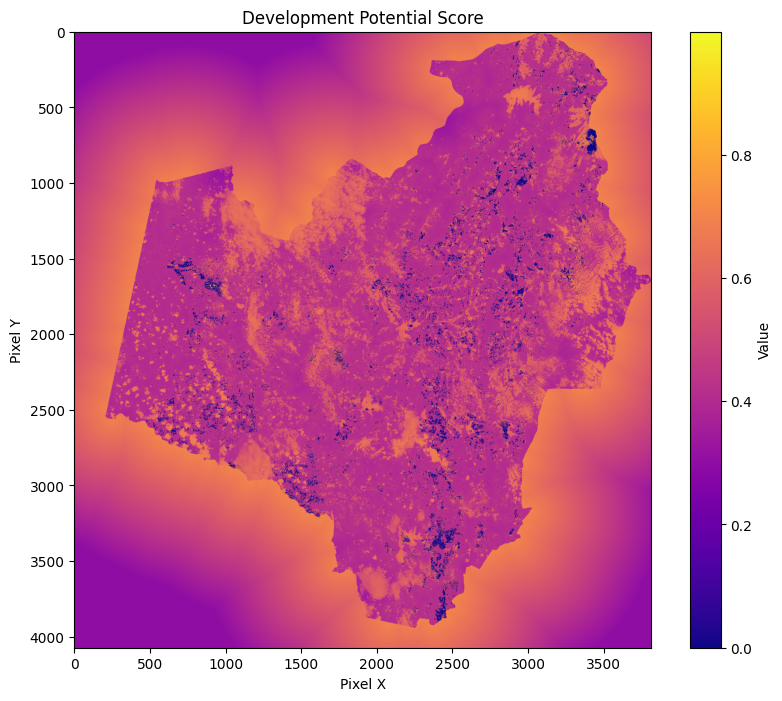

File: potential_score.tif
Shape: (4074, 3815)
Data type: float32
Min value: 0.000
Max value: 1.000
----------------------------------------


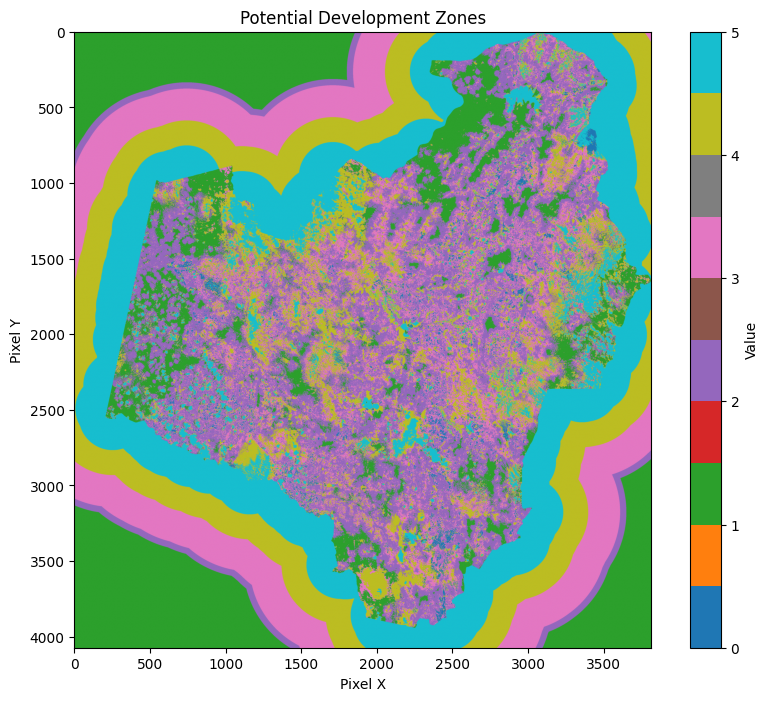

File: potential_zones.tif
Shape: (4074, 3815)
Data type: uint8
Min value: 0.000
Max value: 5.000
----------------------------------------


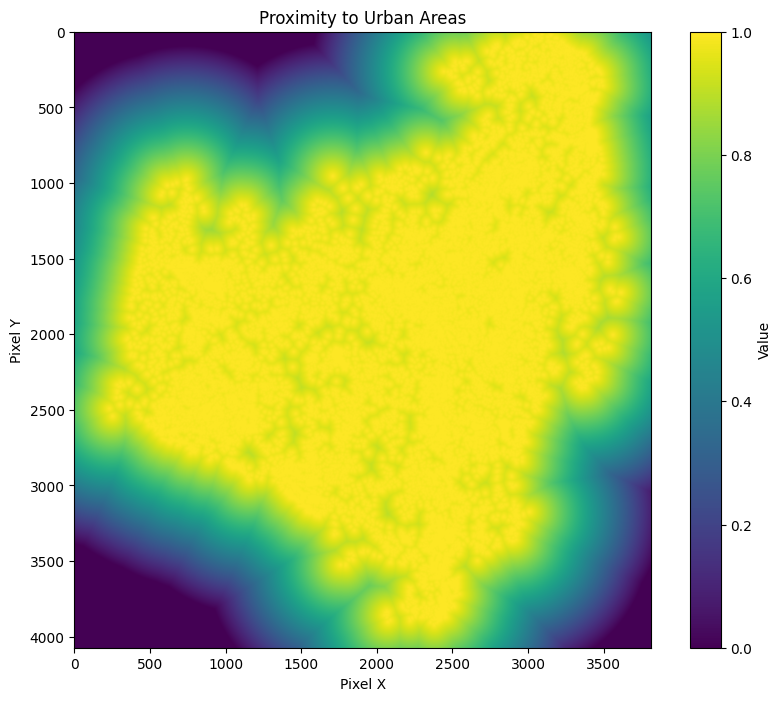

File: proximity_score.tif
Shape: (4074, 3815)
Data type: float32
Min value: 0.000
Max value: 1.000
----------------------------------------


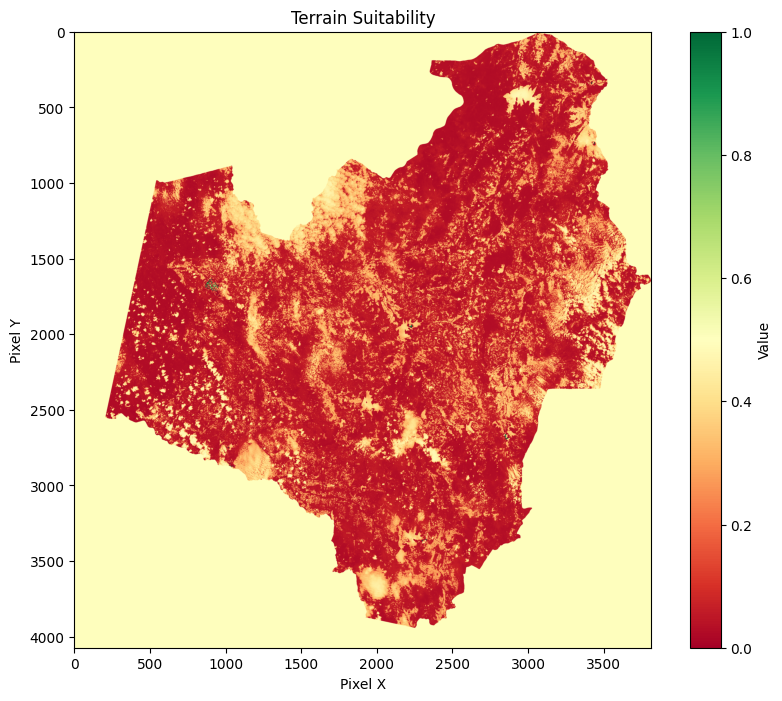

File: terrain_suitability.tif
Shape: (4074, 3815)
Data type: float32
Min value: 0.000
Max value: 1.000
----------------------------------------


In [6]:
# METHOD 1: Using Python/Jupyter (Best for analysis)
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the output directory
OUTPUT_DIR = "../../Potential_Growth_Analysis"

# Function to display TIF files
def display_tif(file_path, title="", cmap='viridis'):
    """Display a TIF file with matplotlib"""
    if os.path.exists(file_path):
        with rasterio.open(file_path) as src:
            data = src.read(1)
            
        plt.figure(figsize=(10, 8))
        plt.imshow(data, cmap=cmap)
        plt.colorbar(label='Value')
        plt.title(title)
        plt.xlabel('Pixel X')
        plt.ylabel('Pixel Y')
        plt.show()
        
        print(f"File: {os.path.basename(file_path)}")
        print(f"Shape: {data.shape}")
        print(f"Data type: {data.dtype}")
        print(f"Min value: {np.nanmin(data):.3f}")
        print(f"Max value: {np.nanmax(data):.3f}")
        print("-" * 40)
    else:
        print(f"File not found: {file_path}")

# Display all generated TIF files
tif_files = [
    ("potential_score.tif", "Development Potential Score", "plasma"),
    ("potential_zones.tif", "Potential Development Zones", "tab10"),
    ("proximity_score.tif", "Proximity to Urban Areas", "viridis"),
    ("terrain_suitability.tif", "Terrain Suitability", "RdYlGn")
]

print("🗺️ VIEWING GENERATED TIF FILES")
print("=" * 50)

for filename, title, colormap in tif_files:
    file_path = os.path.join(OUTPUT_DIR, filename)
    display_tif(file_path, title, colormap)

In [7]:

def load_tif_with_coordinates(file_path):
    """Load TIF file with proper geographic coordinates"""
    if os.path.exists(file_path):
        with rasterio.open(file_path) as src:
            data = src.read(1)
            transform = src.transform
            crs = src.crs
            bounds = src.bounds
            
            print(f"📍 FILE: {os.path.basename(file_path)}")
            print(f"   Shape: {data.shape}")
            print(f"   CRS: {crs}")
            print(f"   Bounds: {bounds}")
            print(f"   Transform: {transform}")
            print(f"   Data range: {np.nanmin(data):.3f} to {np.nanmax(data):.3f}")
            print("-" * 50)
            
            return data, transform, crs, bounds
    else:
        print(f"File not found: {file_path}")
        return None, None, None, None

# Load all TIF files with geographic information
print("📍 TIF FILES WITH GEOGRAPHIC INFORMATION")
print("=" * 50)

for filename, _, _ in tif_files:
    file_path = os.path.join(OUTPUT_DIR, filename)
    load_tif_with_coordinates(file_path)

📍 TIF FILES WITH GEOGRAPHIC INFORMATION
📍 FILE: potential_score.tif
   Shape: (4074, 3815)
   CRS: EPSG:32644
   Bounds: BoundingBox(left=384555.0, bottom=863865.0, right=499005.0, top=986085.0)
   Transform: | 30.00, 0.00, 384555.00|
| 0.00,-30.00, 986085.00|
| 0.00, 0.00, 1.00|
   Data range: 0.000 to 1.000
--------------------------------------------------
📍 FILE: potential_zones.tif
   Shape: (4074, 3815)
   CRS: EPSG:32644
   Bounds: BoundingBox(left=384555.0, bottom=863865.0, right=499005.0, top=986085.0)
   Transform: | 30.00, 0.00, 384555.00|
| 0.00,-30.00, 986085.00|
| 0.00, 0.00, 1.00|
   Data range: 0.000 to 5.000
--------------------------------------------------
📍 FILE: proximity_score.tif
   Shape: (4074, 3815)
   CRS: EPSG:32644
   Bounds: BoundingBox(left=384555.0, bottom=863865.0, right=499005.0, top=986085.0)
   Transform: | 30.00, 0.00, 384555.00|
| 0.00,-30.00, 986085.00|
| 0.00, 0.00, 1.00|
   Data range: 0.000 to 1.000
---------------------------------------------